In [2]:
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns

![alt text](./1.png "Title")

In [2]:
# Model 1
with pm.Model() as model1:
    capability = pm.Beta('capability', alpha=2, beta=2)
    success = pm.Bernoulli('success', p=capability)
    data1 = pd.DataFrame(pm.sample_prior_predictive(samples=500, model=model1))
    data1.head()

![alt text](./2.png "Title")

In [3]:
# Model 2
with pm.Model() as model2:
    capability = pm.Beta('capability', alpha=2, beta=2)
    
    interview = pm.Binomial('interview', n=20, p=capability)
    success = pm.Bernoulli('success', p=capability)
    data2 = pd.DataFrame(pm.sample_prior_predictive(samples=500, model=model2))
    data2.head()

![alt text](./3.png "Title")

In [4]:
# Model 3
with pm.Model() as model3:
    capability = pm.Beta('capability', alpha=2, beta=2)
    
    interview = pm.Binomial('interview', n=20, p=capability)
    gpa = pm.Deterministic('gpa', pm.Binomial('gpa_unscaled', n=16, p=capability) / 4.0)
    success = pm.Bernoulli('success', p=capability)
    
    data3 = pd.DataFrame(pm.sample_prior_predictive(samples=500, model=model3))
    data3.head()

![alt text](./4.png "Title")

In [11]:
def generate_samples(long_interview_question_count=100, interview_question_count=20, capability_correlation=0.7, gpa_correlation=0.8, university_exam_correlation=0.77, highschool_exam_correlation=0.77, wealty_family_ratio=0.05, sample_count=1000):
    with pm.Model() as model:
        
        
        capability = pm.Beta('general_capability', alpha=2, beta=2)
        second_capability = pm.Beta('job_related_knowledge', alpha=2, beta=2)
        
        total_capability = pm.Deterministic('total_capability', capability*capability_correlation + second_capability*(1-capability_correlation))
        
        long_interview = pm.Binomial('long_interview', n=long_interview_question_count, p=total_capability)
        interview = pm.Binomial('interview', n=interview_question_count, p=total_capability)

        gpa_other_factors = pm.Beta('gpa_other_factors', alpha=2, beta=2)
        gpa = pm.Deterministic('gpa', pm.Binomial('gpa_unscaled', n=16, p=capability*gpa_correlation + gpa_other_factors*(1-gpa_correlation)) / 4.0)

        exam_other_factors = pm.Beta('exam_other_factors', alpha=2, beta=2)
        highschool_exam = pm.Binomial('highschool_exam', n=100, p=capability*(1-highschool_exam_correlation) + exam_other_factors*highschool_exam_correlation)
        university_exam = pm.Binomial('university_exam', n=100, p=capability*(1-university_exam_correlation) + exam_other_factors*university_exam_correlation)
        wealty_family = pm.Bernoulli('wealty_family', p=wealty_family_ratio)

        highschool =  pm.Bernoulli('highschool', p=pm.math.switch(highschool_exam >= 75, 1, 0)) 
        university =  pm.Bernoulli('university', p=pm.math.maximum(pm.math.switch(university_exam >= 75, 1, 0), wealty_family))
        #university = pm.math.switch(university_exam >= 90, 1, 0)
        
        return pd.DataFrame(pm.sample_prior_predictive(samples=1000, model=model))

data = generate_samples()
data.head()

,highschool,long_interview,interview,gpa_unscaled,job_related_knowledge,total_capability,gpa,general_capability_logodds__,wealty_family,highschool_exam,gpa_other_factors_logodds__,exam_other_factors_logodds__,gpa_other_factors,university,exam_other_factors,job_related_knowledge_logodds__,university_exam,general_capability
0,1,80,13,14,0.693860,0.807233,3.50,1.781014,0,79,1.388129,0.776574,0.800293,0,0.684941,0.818228,66,0.855822
1,0,72,15,14,0.624594,0.712102,3.50,1.096510,0,62,-0.208160,0.246290,0.448147,0,0.561263,0.509095,65,0.749606
2,0,61,13,13,0.155313,0.628390,3.25,1.593707,0,65,0.438259,0.131390,0.607844,0,0.532800,-1.693526,55,0.831137
3,0,72,11,14,0.595954,0.700578,3.50,1.074318,0,45,-0.712743,-0.681493,0.328993,0,0.335928,0.388633,41,0.745417
4,1,69,14,15,0.452570,0.724778,3.75,1.668967,0,82,1.359992,1.397410,0.795758,1,0.801773,-0.190292,82,0.841438


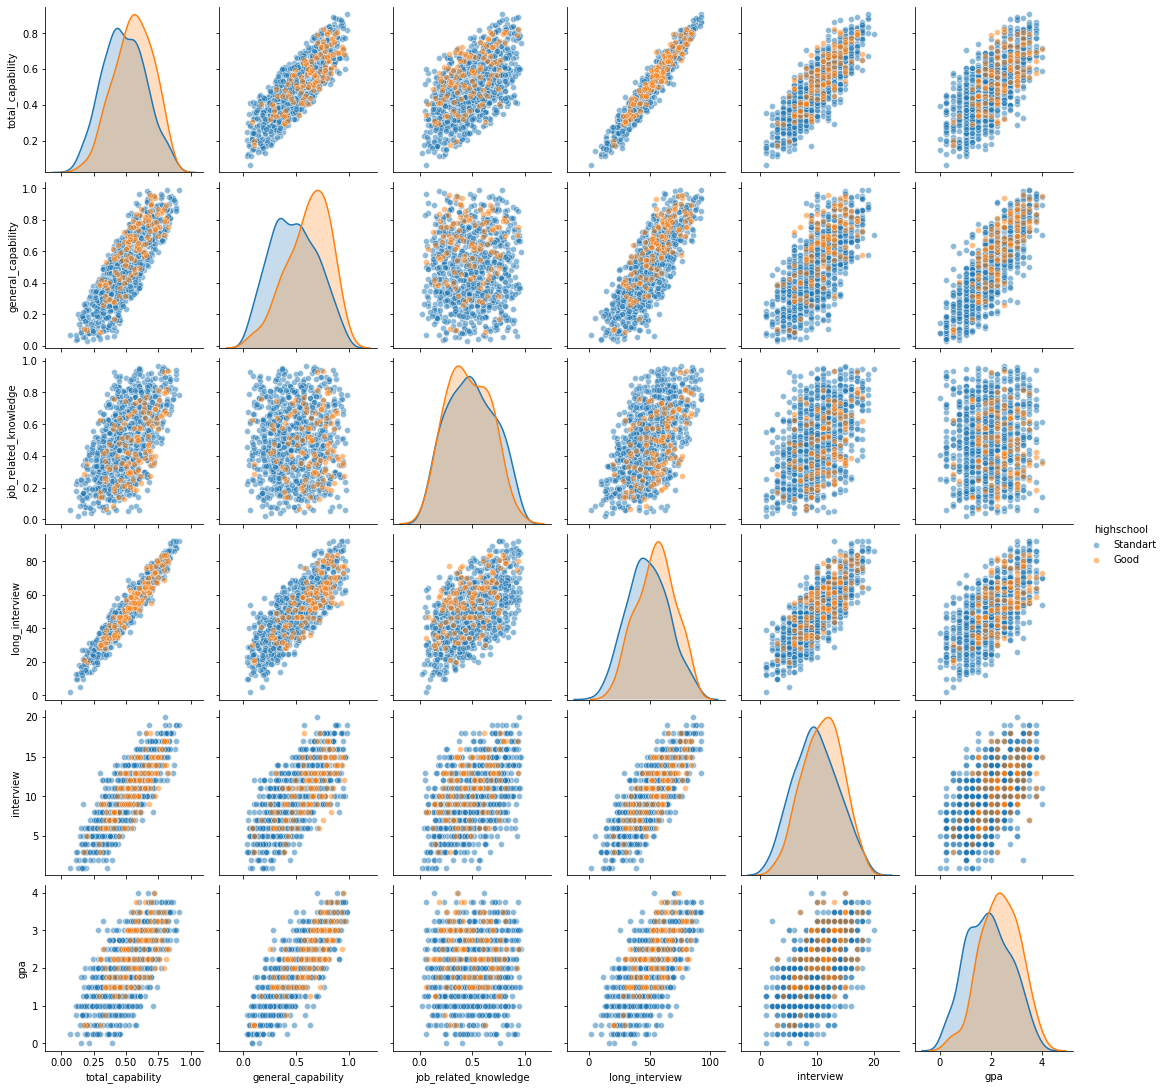

In [23]:
data = generate_samples(capability_correlation=0.6)
data = data.replace({'highschool': {0: 'Standart', 1: 'Good'}}, inplace=False);
g = sns.pairplot(data[['highschool','total_capability', 'general_capability', 'job_related_knowledge', 'long_interview', 'interview', 'gpa']], hue="highschool", diag_kind="kde", diag_kws={'shade':True}, plot_kws={'alpha': 0.5});
g.savefig("output.png")

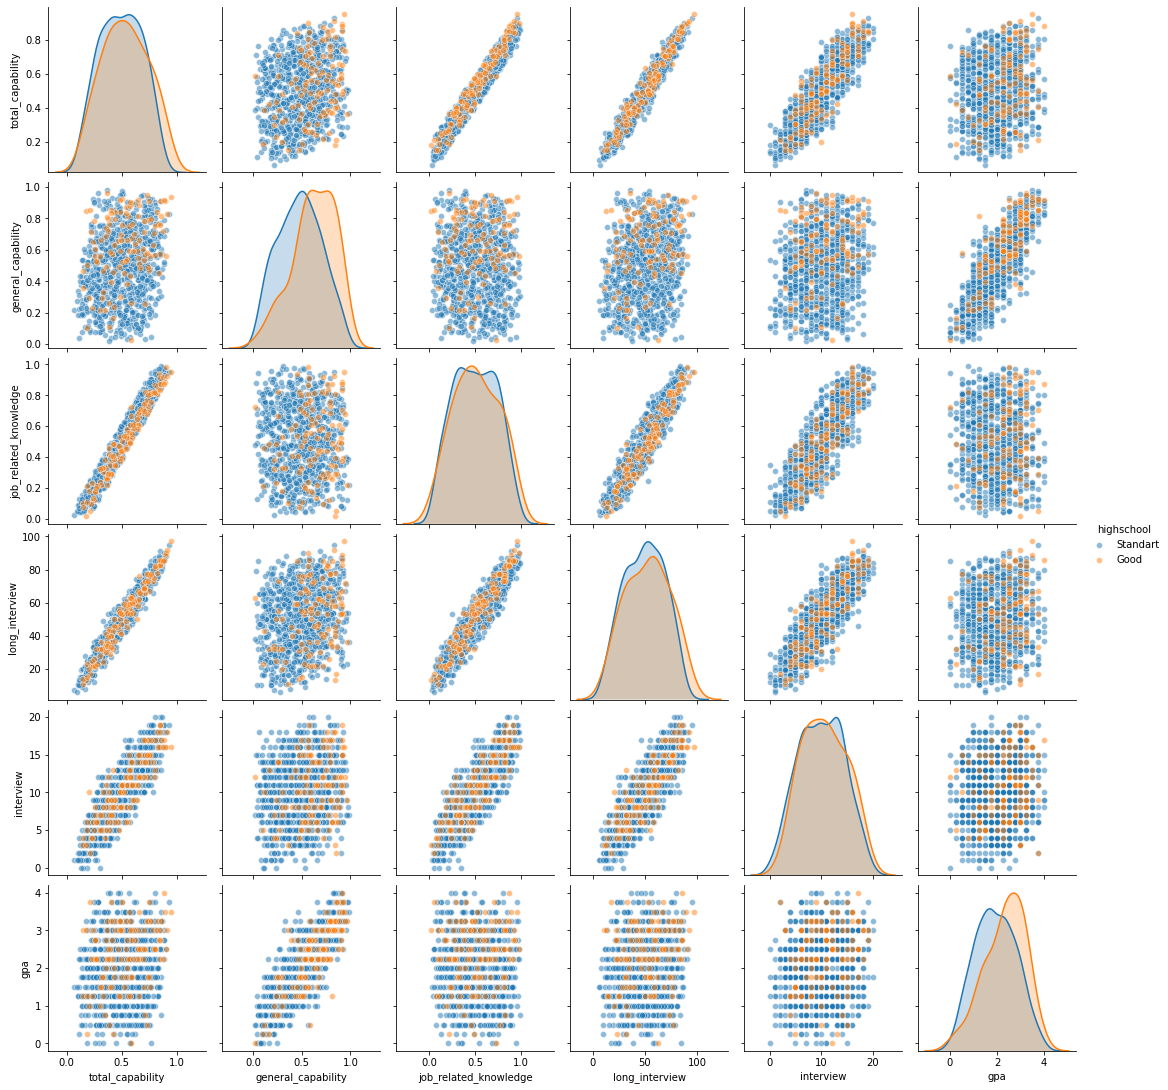

In [20]:
data = generate_samples(capability_correlation=0.2)
data = data.replace({'highschool': {0: 'Standart', 1: 'Good'}}, inplace=False);

g = sns.pairplot(data[['total_capability', 'general_capability', 'job_related_knowledge', 'long_interview', 'interview', 'gpa', 'highschool']], hue="highschool", diag_kind="kde", diag_kws={'shade':True}, plot_kws={'alpha': 0.5});
g.savefig("output2.png")